In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import cartopy.util as util
import matplotlib as mpl
from glob import glob
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
import scipy.stats as stats

mpl.rcParams['figure.figsize'] = [10,4]
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['savefig.dpi'] = 200

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['lines.linewidth']= 2.0
mpl.rcParams['xtick.labelsize']=16
mpl.rcParams['ytick.labelsize']=16

### Loading in files and variables

In [2]:
casePath='/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.BWmaHIST.f19_g17.PMIP4-past1000.002/ocn/proc/tseries/month_1/'
caseName='b.e21.BWmaHIST.f19_g17.PMIP4-past1000.002'

In [3]:
case = casePath + caseName + '.pop.h.' + 'TEMP.*' + '.nc' #sample one 0020-12.nc' 
data = xr.open_mfdataset(case)

monthly_data= {}; months = ['jan','feb','mar','apr','may','jun','jul','aug','sept','oct','nov','dec'] #defining months
month_ind =(1000-850)*12 ;#want to start at the first month of year 1000
for month in months:
    #print(month)
    current_month_data = np.zeros([30,384,320]) ; current_month_data[:] == np.nan #30 years for every latitude and longitude
    year = 0
    for i in range(0,len(data['time'][:360])+1,12 ): #defining years, 360 is 30 x 12
        try:
            current_month_data[year,:,:] =data['TEMP'][:,0,:,:][month_ind+i,:,:]
        except:
            print(' ')
    
        year+=1
    month_ind +=1
    monthly_data[month] = np.mean(current_month_data, axis = 0)

In [4]:
def pop_add_cyclic(data,TLAT,TLONG): 
    nj = TLAT.shape[0] # size of POP grid
    ni = TLONG.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)
    tlon = TLONG
    tlat = TLAT
    tlon = np.where(np.greater_equal(tlon, min(tlon[:,0])), tlon-360., tlon) #make monotoncially increasing
    lon  = np.concatenate((tlon, tlon + 360.), 1) # concatenate to make larger array
    lon = lon[:, xL:xR] #restrict to middle rane
    if ni == 320: # this is the x1 POP grid
        lon[367:-3, 0] = lon[367:-3, 0] + 360.        
    lon = lon - 360.
    lon = np.hstack((lon, lon[:, 0:1] + 360.)) # add in cyclic point
    if ni == 320:
        lon[367:, -1] = lon[367:, -1] - 360.
    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:, 0] = lon[:, 0] - 1e-8
    #-- periodicity
    lat = np.concatenate((tlat, tlat), 1)
    lat = lat[:, xL:xR]
    lat = np.hstack((lat, lat[:,0:1]))
    lon_dim = 1 #ds[v].dims.index('nlon')
    field = data
    field = np.concatenate((field, field), 1)
    field = field[:, xL:xR]
    field = np.concatenate((field, field[:, 0:1]), lon_dim)
    
    return field, lat, lon

In [5]:
from scipy.ndimage import uniform_filter1d

def rolling_mean(a, W, axis=-1):
    # a : Input ndarray
    # W : Window size
    # axis : Axis along which we will apply rolling/sliding mean
    hW = W//2
    L = a.shape[axis]-W+1   
    indexer = [slice(None) for _ in range(a.ndim)]
    indexer[axis] = slice(hW,hW+L)
    return uniform_filter1d(a,W,axis=axis)[tuple(indexer)]

def ENSO_area_mean(var):  
    # assumes 2D field as var input
    # make sure masking is correct, otherwise we get nans
    var = np.ma.masked_invalid(var)
    # resulting variable should have dimensions of depth and time (x)
    ave = np.zeros(var.shape[0])
    # loop over time
    for t in np.arange(var.shape[0]):
        ave[t] = np.ma.average(var[t,167:206,203:248])
    return ave

### Get the lat and lon locations for the El Nino region: 

In [6]:
data['TLAT'][206,50].values

array(5.18019218)

In [7]:
data['TLAT'][167,50].values

array(-5.2090898)

In [8]:
abs(data['TLONG'][50,203].values-360)

171.06249474233516

In [9]:
abs(data['TLONG'][50,248].values-360)

120.43749333356618

### Pulling SST and monthly 

- Pull out the Sea Surface Temperature (makes things faster)

In [10]:
data = data.TEMP[:,0,:,:]
data

<xarray.DataArray 'TEMP' (time: 12000, nlat: 384, nlon: 320)>
dask.array<getitem, shape=(12000, 384, 320), dtype=float32, chunksize=(600, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    z_t      float32 500.0
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time     (time) object 0850-02-01 00:00:00 ... 1850-01-01 00:00:00
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

- Monthly Data for comparison (years 1000-1030)

In [11]:
monthlydata = data.sel(time=slice('1000-01-01 00:00:00','1030-12-31 00:00:00')).groupby('time.month').mean(dim='time')

- The code below creates post eruption monthly means for all volcanoes

In [14]:
samalas_post_1yr = data.sel(time=slice('1257-07-01 00:00:00','1258-07-01 00:00:00')).groupby('time.month').mean(dim='time')
unident1_post_1yr = data.sel(time=slice('1458-08-01 00:00:00','1459-08-01 00:00:00')).groupby('time.month').mean(dim='time')
tambora_post_1yr = data.sel(time=slice('1815-05-01 00:00:00','1816-05-01 00:00:00')).groupby('time.month').mean(dim='time')
unident2_post_1yr = data.sel(time=slice('1230-08-01 00:00:00','1231-08-01 00:00:00')).groupby('time.month').mean(dim='time')
laki_post_1yr = data.sel(time=slice('1783-11-01 00:00:00','1784-11-01 00:00:00')).groupby('time.month').mean(dim='time')
unident3_post_1yr = data.sel(time=slice('1809-11-01 00:00:00','1810-11-01 00:00:00')).groupby('time.month').mean(dim='time')
unident4_post_1yr = data.sel(time=slice('1108-02-01 00:00:00','1109-02-01 00:00:00')).groupby('time.month').mean(dim='time')
huay_post_1yr = data.sel(time=slice('1600-03-01 00:00:00','1601-03-01 00:00:00')).groupby('time.month').mean(dim='time')
parker_post_1yr = data.sel(time=slice('1641-01-01 00:00:00','1642-01-01 00:00:00')).groupby('time.month').mean(dim='time')
unident5_post_1yr = data.sel(time=slice('1171-02-01 00:00:00','1172-02-01 00:00:00')).groupby('time.month').mean(dim='time')

- Creating Anomalies

In [15]:
samalas_post_1yr_anomaly = samalas_post_1yr-monthlydata
unident1_post_1yr_anomaly = unident1_post_1yr-monthlydata
tambora_post_1yr_anomaly = tambora_post_1yr-monthlydata
unident2_post_1yr_anomaly = unident2_post_1yr-monthlydata
laki_post_1yr_anomaly = laki_post_1yr-monthlydata
unident3_post_1yr_anomaly = unident3_post_1yr-monthlydata
unident4_post_1yr_anomaly = unident4_post_1yr-monthlydata
huay_post_1yr_anomaly = huay_post_1yr-monthlydata
parker_post_1yr_anomaly = parker_post_1yr-monthlydata
unident5_post_1yr_anomaly = unident5_post_1yr-monthlydata

- Rolling Means

In [ ]:
samalas_post_1yr_rm = rolling_mean(samalas_post_1yr_anomaly,5,axis=0)
unident1_post_1yr_rm = rolling_mean(unident1_post_1yr_anomaly,5,axis=0)
tambora_post_1yr_rm = rolling_mean(tambora_post_1yr_anomaly,5,axis=0)
unident2_post_1yr_rm = rolling_mean(unident2_post_1yr_anomaly,5,axis=0)
laki_post_1yr_rm = rolling_mean(laki_post_1yr_anomaly,5,axis=0)
unident3_post_1yr_rm = rolling_mean(unident3_post_1yr_anomaly,5,axis=0)
unident4_post_1yr_rm = rolling_mean(unident4_post_1yr_anomaly,5,axis=0)
huay_post_1yr_rm = rolling_mean(huay_post_1yr_anomaly,5,axis=0)
parker_post_1yr_rm = rolling_mean(parker_post_1yr_anomaly,5,axis=0)
unident5_post_1yr_rm = rolling_mean(unident5_post_1yr_anomaly,5,axis=0)

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


- Enso Area Means

In [16]:
samalas_post_1yr_EAM = ENSO_area_mean(samalas_post_1yr_rm)
unident1_post_1yr_EAM = ENSO_area_mean(unident1_post_1yr_rm)
tambora_post_1yr_EAM = ENSO_area_mean(tambora_post_1yr_rm)
unident2_post_1yr_EAM = ENSO_area_mean(unident2_post_1yr_rm)
laki_post_1yr_EAM = ENSO_area_mean(laki_post_1yr_rm)
unident3_post_1yr_EAM = ENSO_area_mean(unident3_post_1yr_rm)
unident4_post_1yr_EAM = ENSO_area_mean(unident4_post_1yr_rm)
huay_post_1yr_EAM = ENSO_area_mean(huay_post_1yr_rm)
parker_post_1yr_EAM = ENSO_area_mean(parker_post_1yr_rm)
unident5_post_1yr_EAM = ENSO_area_mean(unident5_post_1yr_rm)

- Run "Pop Add Cyclic" on yearly averages

In [ ]:
plot_data_samalas_post_1yr, new_lats, new_lons = pop_add_cyclic(samalas_post_1yr_anomaly.mean(dim = 'month'),data['TLAT'],data['TLONG'])
plot_data_unident1_post_1yr, new_lats, new_lons = pop_add_cyclic(unident1_post_1yr_anomaly.mean(dim = 'month'),data['TLAT'],data['TLONG'])
plot_data_tambora_post_1yr, new_lats, new_lons = pop_add_cyclic(tambora_post_1yr_anomaly.mean(dim = 'month'),data['TLAT'],data['TLONG'])
plot_data_unident2_post_1yr, new_lats, new_lons = pop_add_cyclic(unident2_post_1yr_anomaly.mean(dim = 'month'),data['TLAT'],data['TLONG'])
plot_data_laki_post_1yr, new_lats, new_lons = pop_add_cyclic(laki_post_1yr_anomaly.mean(dim = 'month'),data['TLAT'],data['TLONG'])
plot_data_unident3_post_1yr, new_lats, new_lons = pop_add_cyclic(unident3_post_1yr_anomaly.mean(dim = 'month'),data['TLAT'],data['TLONG'])
plot_data_unident4_post_1yr, new_lats, new_lons = pop_add_cyclic(unident4_post_1yr_anomaly.mean(dim = 'month'),data['TLAT'],data['TLONG'])
plot_data_huay_post_1yr, new_lats, new_lons = pop_add_cyclic(huay_post_1yr_anomaly.mean(dim = 'month'),data['TLAT'],data['TLONG'])
plot_data_parker_post_1yr, new_lats, new_lons = pop_add_cyclic(parker_post_1yr_anomaly.mean(dim = 'month'),data['TLAT'],data['TLONG'])
plot_data_unident5_post_1yr, new_lats, new_lons = pop_add_cyclic(unident5_post_1yr_anomaly.mean(dim = 'month'),data['TLAT'],data['TLONG'])

- Average all the plot datas

In [18]:
plot_data_1yr_average = (plot_data_samalas_post_1yr +
                         plot_data_unident1_post_1yr +
                         plot_data_tambora_post_1yr +
                         plot_data_unident2_post_1yr +
                         plot_data_laki_post_1yr +
                         plot_data_unident3_post_1yr +
                         plot_data_unident4_post_1yr +
                         plot_data_huay_post_1yr +
                         plot_data_parker_post_1yr +
                         plot_data_unident5_post_1yr) / 10

In [ ]:
#plot_data_1yr_average.to_netcdf('plot_data_1yr_av.nc')

In [ ]:
#plot_data_1yr_average = xr.open_dataset('plot_data_1yr_av.nc')

- Plot

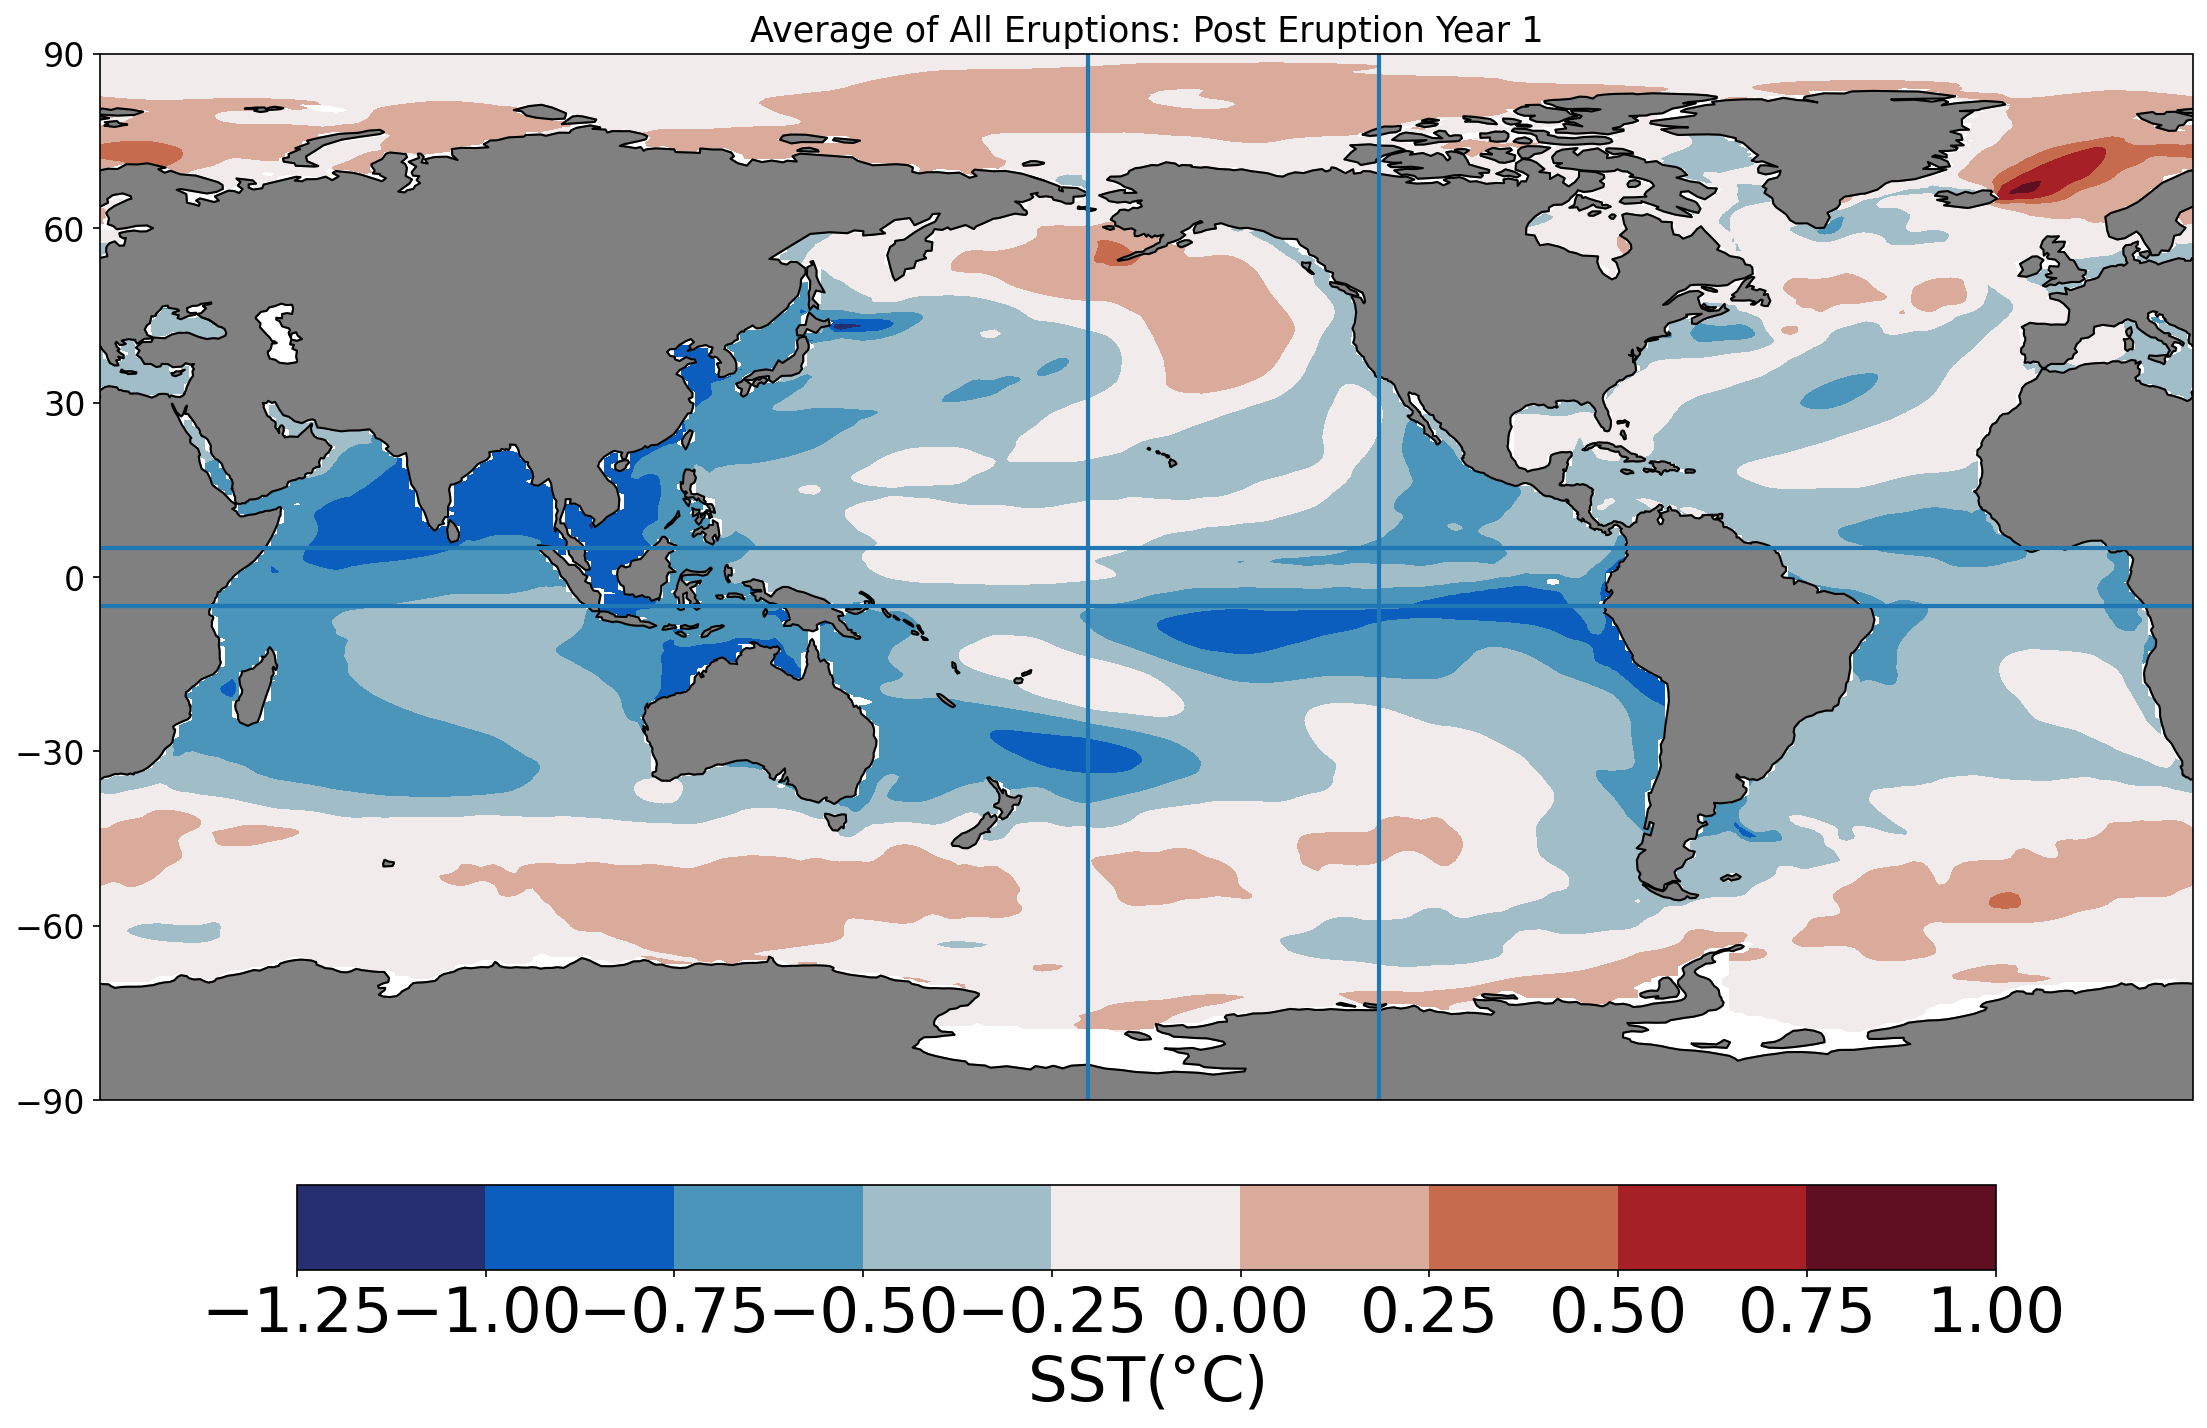

In [58]:
projection=ccrs.PlateCarree(central_longitude = -160)
fig,ax= plt.subplots(figsize =(18,15),subplot_kw=dict(projection=projection))

ax.add_feature(cfeature.LAND, color = 'gray')
ax.add_feature(cfeature.COASTLINE)
ax.set_global()

levels=np.arrange(-1.25,1.25,.25)
p = plt.contourf(new_lons,new_lats, plot_data_1yr_average,levels=levels,
                transform=ccrs.PlateCarree(),cmap= 'cmo.balance',zorder=-1) #'cmo.balance' or 'coolwarm'
#p = plt.contourf(new_lons,new_lats, plot_data_1yr_average,
                #transform=ccrs.PlateCarree(),vmin=-1.5, vmax=1.5, levels= 8, cmap= 'cmo.balance',zorder=-1)

ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=projection)
plt.axhline(y=5)
plt.axhline(y=-5)
plt.axvline(x=-10)
plt.axvline(x=40)
plt.title('Average of All Eruptions: Post Eruption Year 1')
cbar = plt.colorbar(p, orientation='horizontal', pad=0.05, fraction=0.05, ax=ax)
cbar.ax.tick_params(labelsize=30)
cbar.set_label('SST' + "($\degree$C)", size = 30)

In [ ]:
fig,ax= plt.subplots(figsize =(18,13),subplot_kw=dict(projection=ccrs.Robinson(central_longitude = 155)))
    fig,ax= plt.subplots(figsize =(18,13),subplot_kw=dict(projection=ccrs.Robinson(central_longitude=305.0)),facecolor='white')

    ax.add_feature(cfeature.COASTLINE)
    ax.set_global()

    levels=np.arange(-12.5,12.51,0.5)
    p = plt.contourf(lon,cesm_historical_1982_2010['lat'],obs_sub_from_cesm, levels=levels,
                    transform=ccrs.PlateCarree(),cmap = cmocean.cm.balance,zorder=-1) # Update to: cmocean.cm.balance) in dkrz
    p = plt.contourf(new_lons,new_lats, plot_data_1yr_average,levels=levels,
                    transform=ccrs.PlateCarree(),cmap= 'cmo.balance',zorder=-1)

    cbar = plt.colorbar(p, orientation='horizontal', pad=0.05, fraction=0.05,ax=ax)
    cbar.ax.tick_params(labelsize=30)
    cbar.set_label('SST' + "($\degree$C)", size = 30)
    plt.title('Average of All Eruptions: Post Eruption Year 1',size = 35)
    plt.show()
    plt.close()


### Post Year 2

In [12]:
samalas_post_2yr = data.sel(time=slice('1258-07-01 00:00:00','1259-07-01 00:00:00')).groupby('time.month').mean(dim='time')
unident1_post_2yr = data.sel(time=slice('1459-08-01 00:00:00','1460-08-01 00:00:00')).groupby('time.month').mean(dim='time')
tambora_post_2yr = data.sel(time=slice('1816-05-01 00:00:00','1817-05-01 00:00:00')).groupby('time.month').mean(dim='time')
unident2_post_2yr = data.sel(time=slice('1231-08-01 00:00:00','1232-08-01 00:00:00')).groupby('time.month').mean(dim='time')
laki_post_2yr = data.sel(time=slice('1784-11-01 00:00:00','1785-11-01 00:00:00')).groupby('time.month').mean(dim='time')
unident3_post_2yr = data.sel(time=slice('1811-11-01 00:00:00','1812-11-01 00:00:00')).groupby('time.month').mean(dim='time')
unident4_post_2yr = data.sel(time=slice('1110-02-01 00:00:00','1111-02-01 00:00:00')).groupby('time.month').mean(dim='time')
huay_post_2yr = data.sel(time=slice('1601-03-01 00:00:00','1602-03-01 00:00:00')).groupby('time.month').mean(dim='time')
parker_post_2yr = data.sel(time=slice('1642-01-01 00:00:00','1643-01-01 00:00:00')).groupby('time.month').mean(dim='time')
unident5_post_2yr = data.sel(time=slice('1172-02-01 00:00:00','1173-02-01 00:00:00')).groupby('time.month').mean(dim='time')

In [13]:
samalas_post_2yr_anomaly = samalas_post_2yr-monthlydata
unident1_post_2yr_anomaly = unident1_post_2yr-monthlydata
tambora_post_2yr_anomaly = tambora_post_2yr-monthlydata
unident2_post_2yr_anomaly = unident2_post_2yr-monthlydata
laki_post_2yr_anomaly = laki_post_2yr-monthlydata
unident3_post_2yr_anomaly = unident3_post_2yr-monthlydata
unident4_post_2yr_anomaly = unident4_post_2yr-monthlydata
huay_post_2yr_anomaly = huay_post_2yr-monthlydata
parker_post_2yr_anomaly = parker_post_2yr-monthlydata
unident5_post_2yr_anomaly = unident5_post_2yr-monthlydata

In [14]:
samalas_post_2yr_rm = rolling_mean(samalas_post_2yr_anomaly,5,axis=0)
unident1_post_2yr_rm = rolling_mean(unident1_post_2yr_anomaly,5,axis=0)
tambora_post_2yr_rm = rolling_mean(tambora_post_2yr_anomaly,5,axis=0)
unident2_post_2yr_rm = rolling_mean(unident2_post_2yr_anomaly,5,axis=0)
laki_post_2yr_rm = rolling_mean(laki_post_2yr_anomaly,5,axis=0)
unident3_post_2yr_rm = rolling_mean(unident3_post_2yr_anomaly,5,axis=0)
unident4_post_2yr_rm = rolling_mean(unident4_post_2yr_anomaly,5,axis=0)
huay_post_2yr_rm = rolling_mean(huay_post_2yr_anomaly,5,axis=0)
parker_post_2yr_rm = rolling_mean(parker_post_2yr_anomaly,5,axis=0)
unident5_post_2yr_rm = rolling_mean(unident5_post_2yr_anomaly,5,axis=0)

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/ssg/ch/usr/jupyt

In [15]:
samalas_post_2yr_EAM = ENSO_area_mean(samalas_post_2yr_rm)
unident1_post_2yr_EAM = ENSO_area_mean(unident1_post_2yr_rm)
tambora_post_2yr_EAM = ENSO_area_mean(tambora_post_2yr_rm)
unident2_post_2yr_EAM = ENSO_area_mean(unident2_post_2yr_rm)
laki_post_2yr_EAM = ENSO_area_mean(laki_post_2yr_rm)
unident3_post_2yr_EAM = ENSO_area_mean(unident3_post_2yr_rm)
unident4_post_2yr_EAM = ENSO_area_mean(unident4_post_2yr_rm)
huay_post_2yr_EAM = ENSO_area_mean(huay_post_2yr_rm)
parker_post_2yr_EAM = ENSO_area_mean(parker_post_2yr_rm)
unident5_post_2yr_EAM = ENSO_area_mean(unident5_post_2yr_rm)

In [16]:
plot_data_samalas_post_2yr, new_lats, new_lons = pop_add_cyclic(samalas_post_2yr_anomaly.mean(dim = 'month'),data['TLAT'],data['TLONG'])
plot_data_unident1_post_2yr, new_lats, new_lons = pop_add_cyclic(unident1_post_2yr_anomaly.mean(dim = 'month'),data['TLAT'],data['TLONG'])
plot_data_tambora_post_2yr, new_lats, new_lons = pop_add_cyclic(tambora_post_2yr_anomaly.mean(dim = 'month'),data['TLAT'],data['TLONG'])
plot_data_unident2_post_2yr, new_lats, new_lons = pop_add_cyclic(unident2_post_2yr_anomaly.mean(dim = 'month'),data['TLAT'],data['TLONG'])
plot_data_laki_post_2yr, new_lats, new_lons = pop_add_cyclic(laki_post_2yr_anomaly.mean(dim = 'month'),data['TLAT'],data['TLONG'])
plot_data_unident3_post_2yr, new_lats, new_lons = pop_add_cyclic(unident3_post_2yr_anomaly.mean(dim = 'month'),data['TLAT'],data['TLONG'])
plot_data_unident4_post_2yr, new_lats, new_lons = pop_add_cyclic(unident4_post_2yr_anomaly.mean(dim = 'month'),data['TLAT'],data['TLONG'])
plot_data_huay_post_2yr, new_lats, new_lons = pop_add_cyclic(huay_post_2yr_anomaly.mean(dim = 'month'),data['TLAT'],data['TLONG'])
plot_data_parker_post_2yr, new_lats, new_lons = pop_add_cyclic(parker_post_2yr_anomaly.mean(dim = 'month'),data['TLAT'],data['TLONG'])
plot_data_unident5_post_2yr, new_lats, new_lons = pop_add_cyclic(unident5_post_2yr_anomaly.mean(dim = 'month'),data['TLAT'],data['TLONG'])

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/ssg/ch/usr/jupyt

In [17]:
plot_data_2yr_average = (plot_data_samalas_post_2yr +
                         plot_data_unident1_post_2yr +
                         plot_data_tambora_post_2yr +
                         plot_data_unident2_post_2yr +
                         plot_data_laki_post_2yr +
                         plot_data_unident3_post_2yr +
                         plot_data_unident4_post_2yr +
                         plot_data_huay_post_2yr +
                         plot_data_parker_post_2yr +
                         plot_data_unident5_post_2yr) / 10

In [35]:
plot_data_2yr_average.shape

(384, 321)

- Saving data to rerun later if needed

In [59]:
np.savetxt('plot_data_2yr_average.csv', plot_data_2yr_average, delimiter = ',')

In [60]:
np.savetxt('new_lats_yr2.csv',new_lats, delimiter = ',')

In [61]:
np.savetxt('new_lons_yr2.csv',new_lons, delimiter = ',')

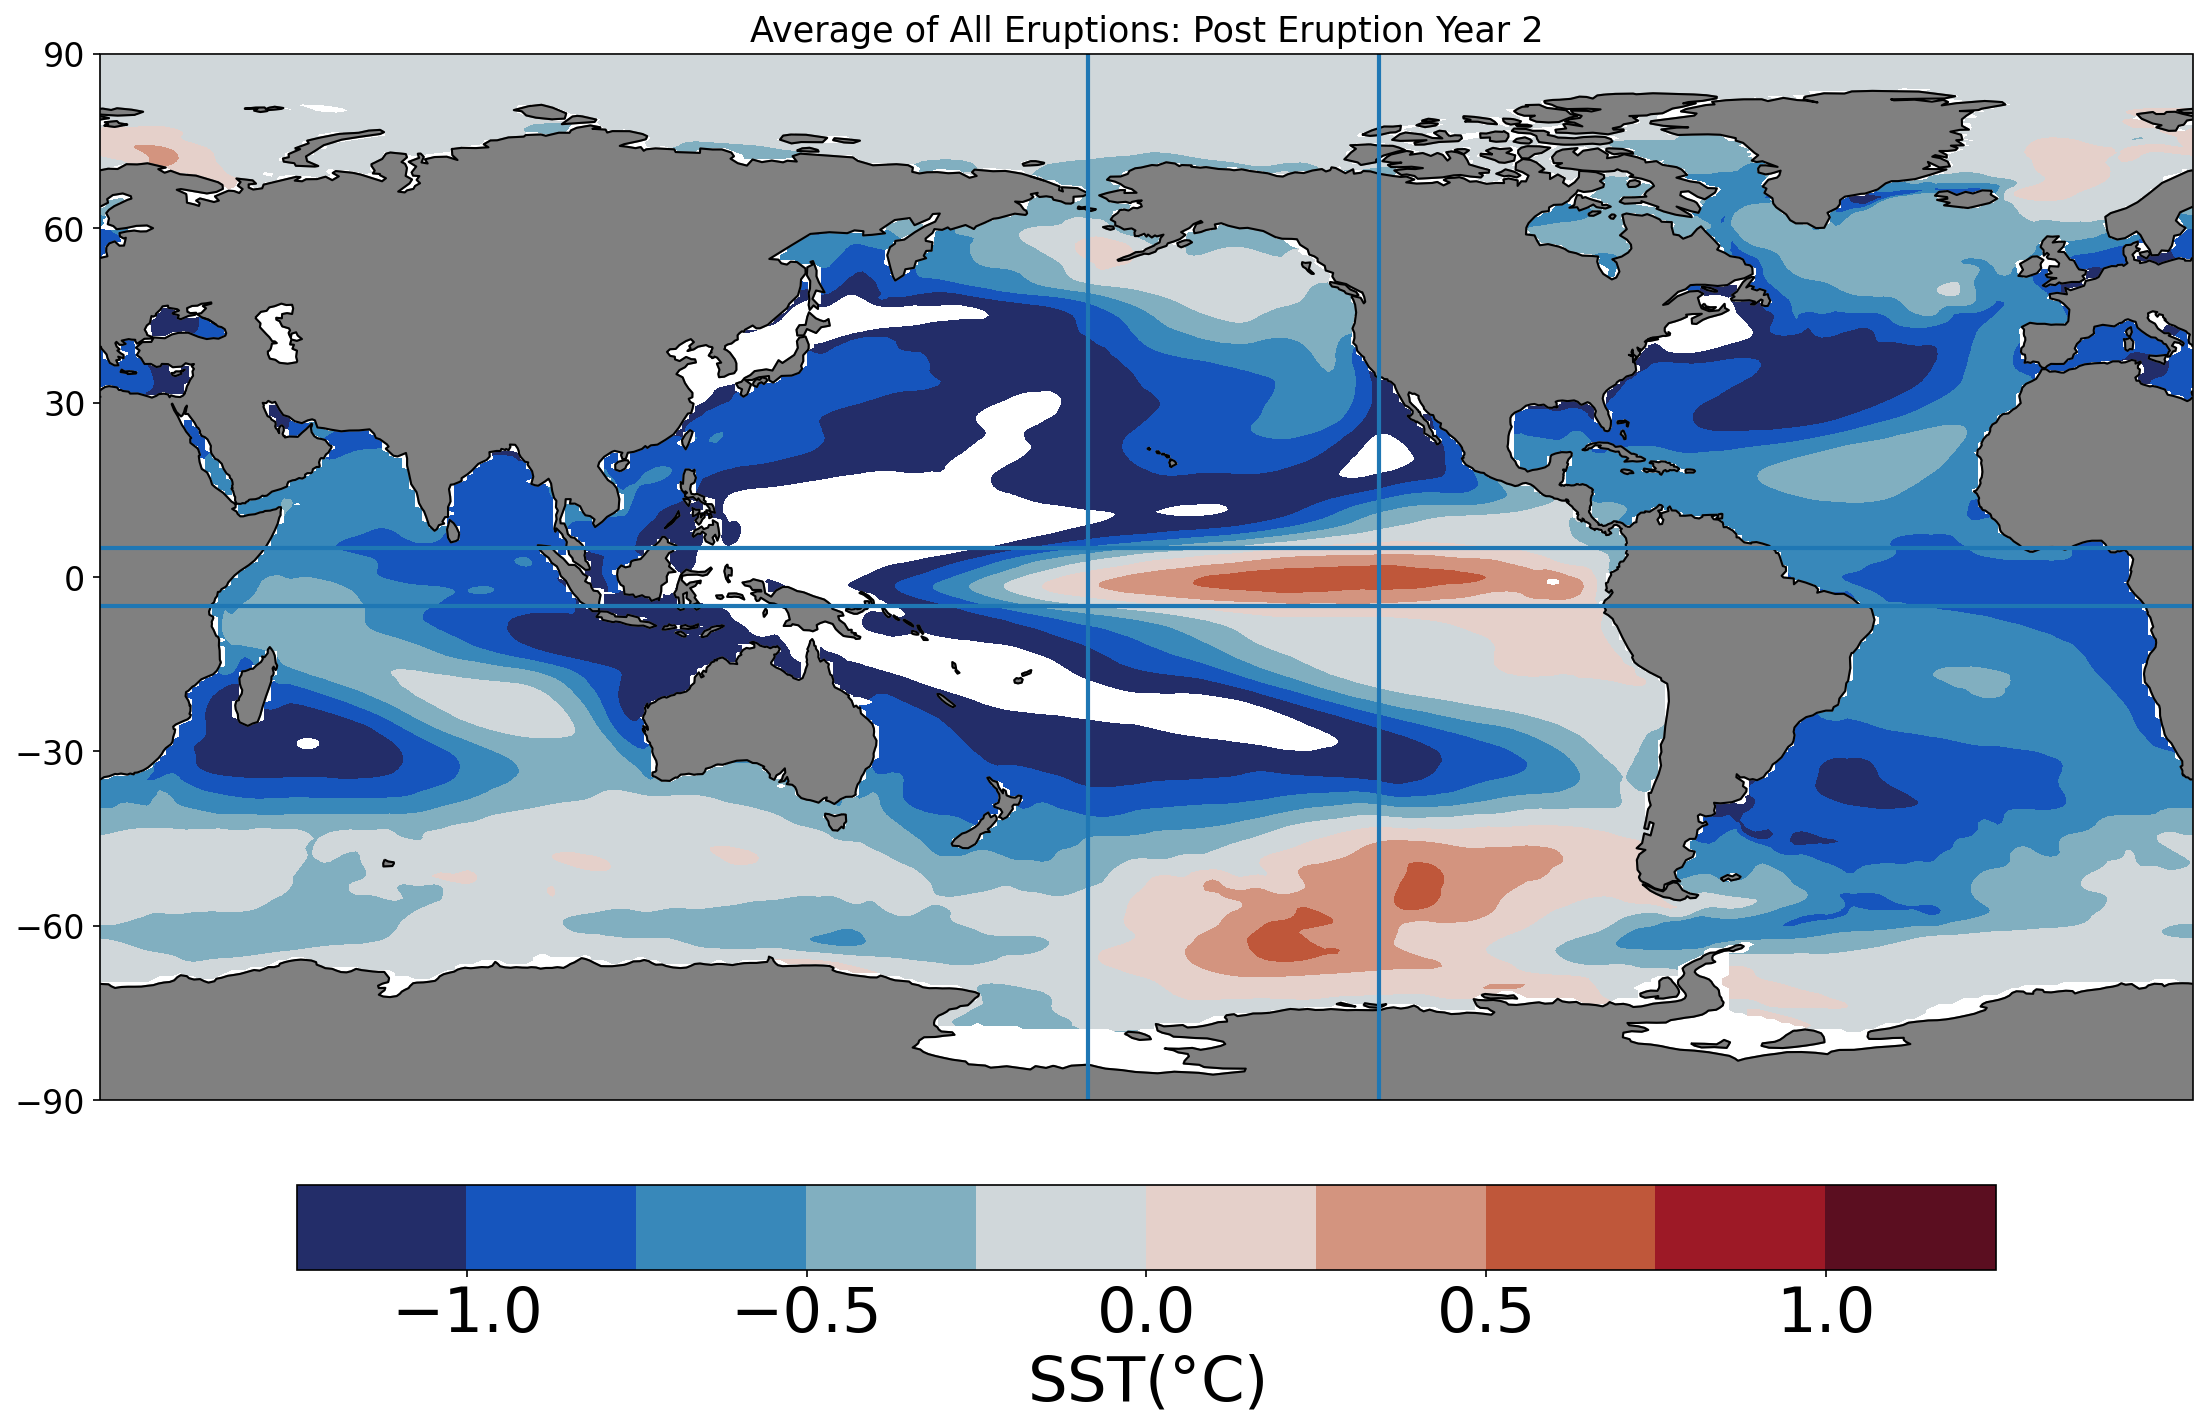

In [18]:
projection=ccrs.PlateCarree(central_longitude = -160)
fig,ax= plt.subplots(figsize =(18,15),subplot_kw=dict(projection=projection))

ax.add_feature(cfeature.LAND, color = 'gray')
ax.add_feature(cfeature.COASTLINE)
ax.set_global()

levels=np.arange(-1.25,1.3,0.25)
p = plt.contourf(new_lons,new_lats, plot_data_2yr_average,levels = levels,
                 transform=ccrs.PlateCarree(),cmap= 'cmo.balance',zorder=-1) #'cmo.balance' or 'coolwarm'
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=projection)
plt.axhline(y=5)
plt.axhline(y=-5)
plt.axvline(x=-10)
plt.axvline(x=40)
plt.title('Average of All Eruptions: Post Eruption Year 2')
cbar = plt.colorbar(p, orientation='horizontal', pad=0.05, fraction=0.05,ax=ax)
cbar.ax.tick_params(labelsize=30)
cbar.set_label('SST' + "($\degree$C)", size = 30)

#First see plot to see ranges, if it fits, add levels = (-1.25, 1.25, .25) to thep=plt.contourf line

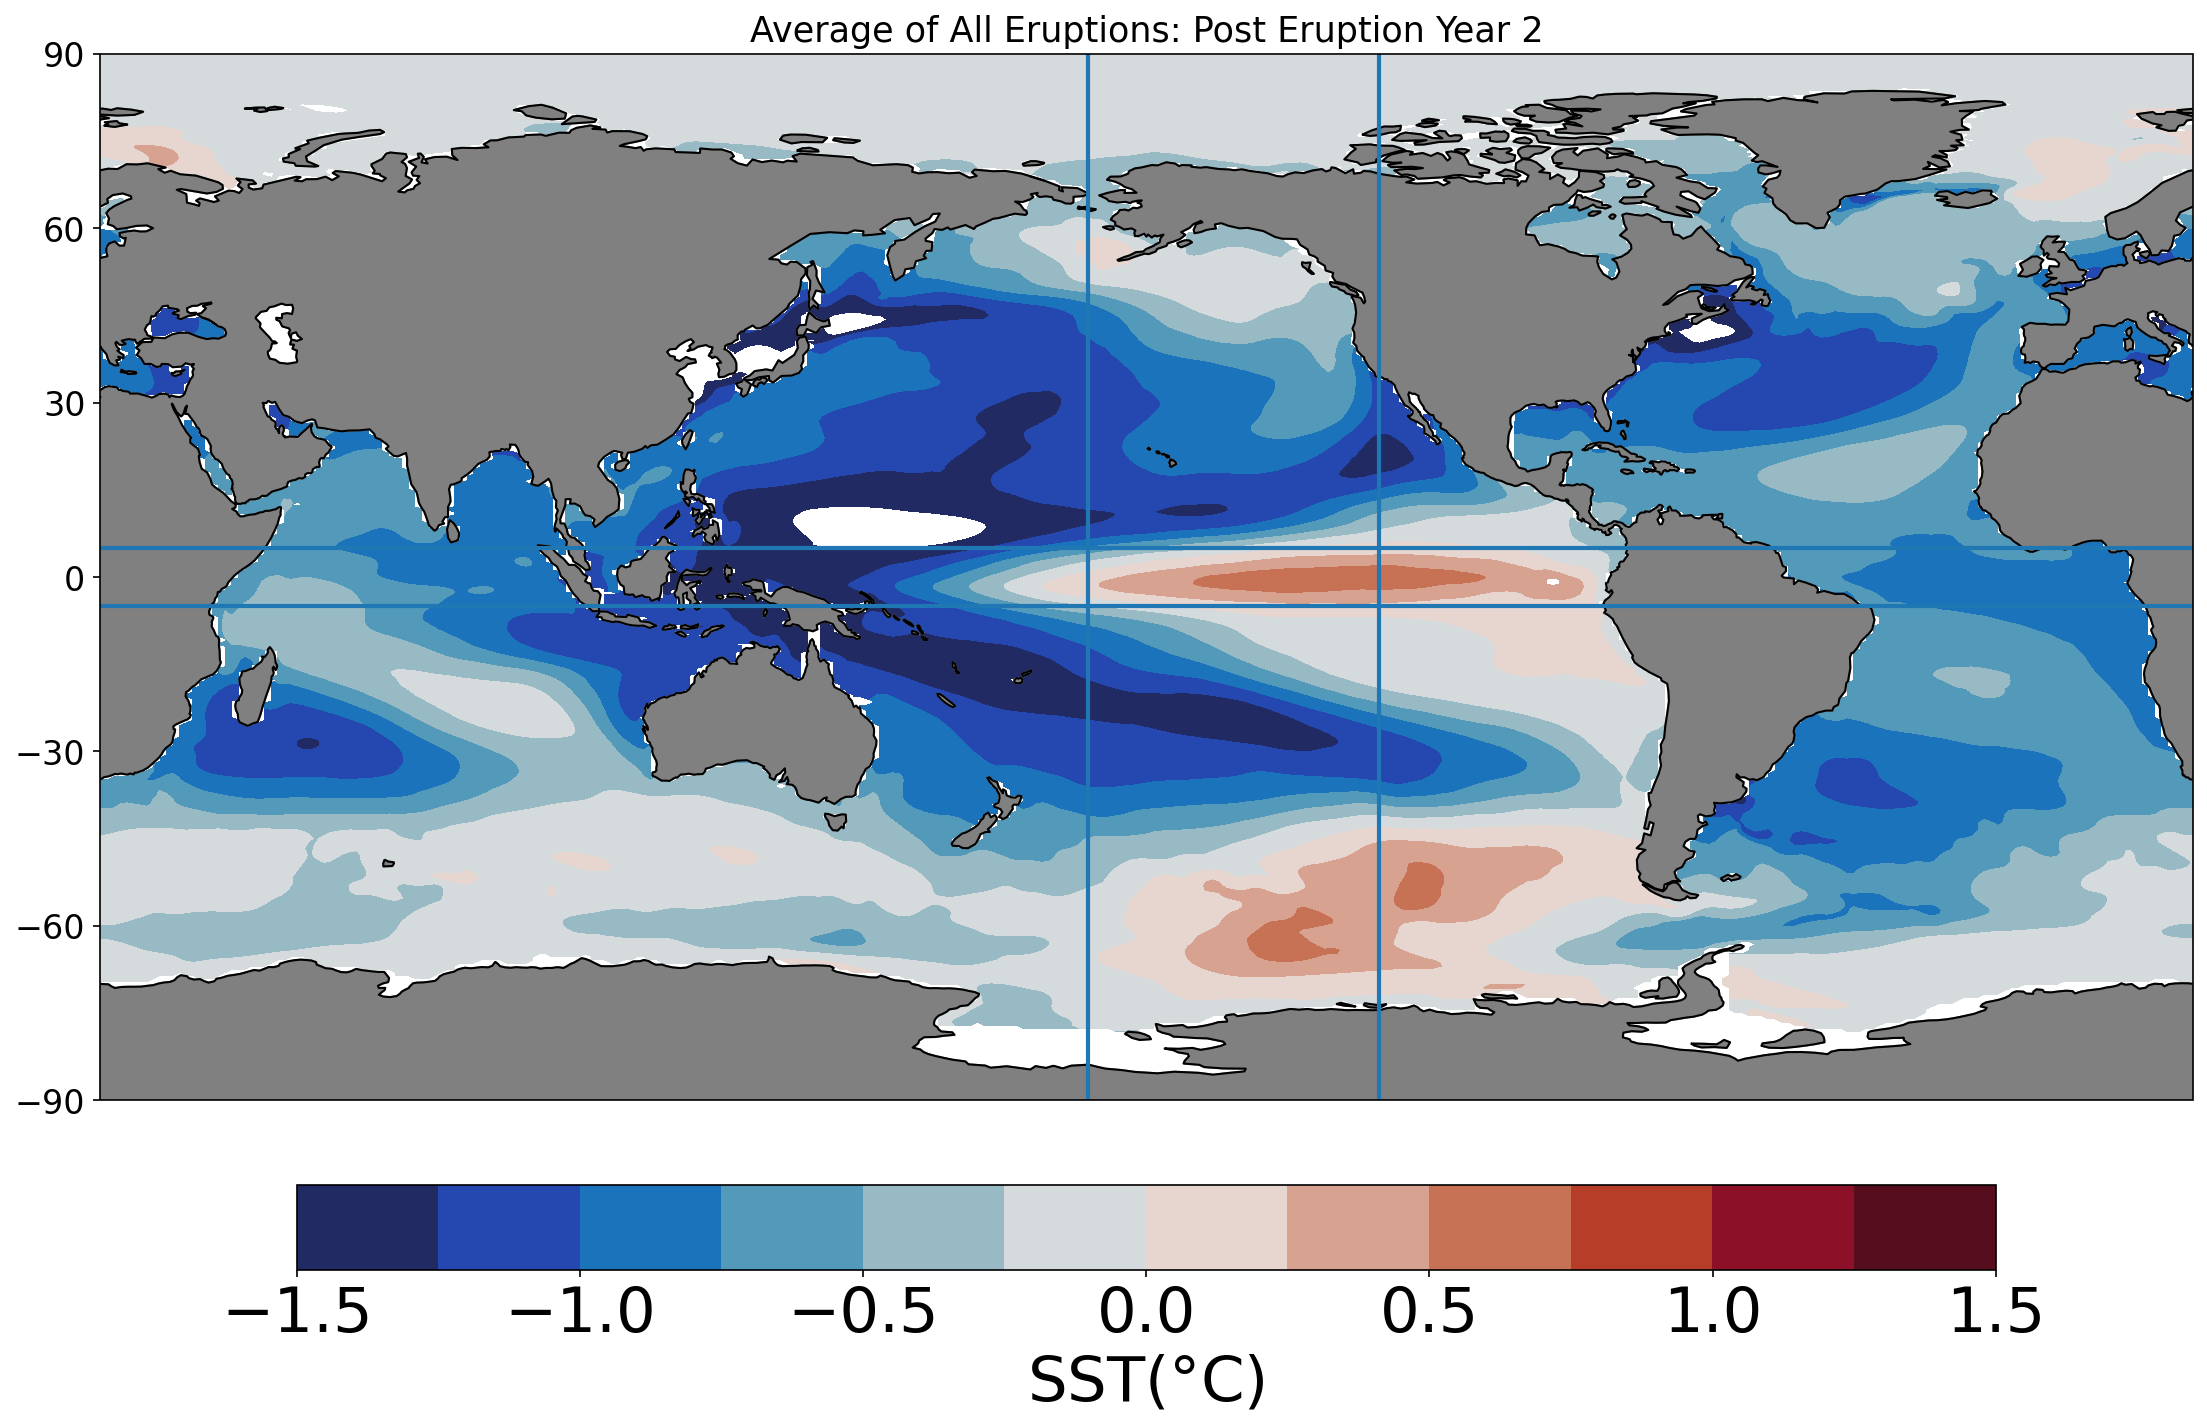

In [39]:
projection=ccrs.PlateCarree(central_longitude = -160)
fig,ax= plt.subplots(figsize =(18,15),subplot_kw=dict(projection=projection))

ax.add_feature(cfeature.LAND, color = 'gray')
ax.add_feature(cfeature.COASTLINE)
ax.set_global()

levels=np.arange(-1.5,1.6,0.25)
p = plt.contourf(new_lons,new_lats, plot_data_2yr_average,levels=levels,
                transform=ccrs.PlateCarree(),cmap = cmocean.cm.balance,zorder=-1)
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=projection)
plt.axhline(y=5)
plt.axhline(y=-5)
plt.axvline(x=-10)
plt.axvline(x=40)
plt.title('Average of All Eruptions: Post Eruption Year 2')
cbar = plt.colorbar(p, orientation='horizontal', pad=0.05, fraction=0.05,ax=ax)
cbar.ax.tick_params(labelsize=30)
cbar.set_label('SST' + "($\degree$C)", size = 30)

In [2]:
plot_data_2yr_average = np.loadtxt('plot_data_2yr_average.csv', delimiter = ',')

In [3]:
new_lats = np.loadtxt('new_lats_yr2.csv', delimiter = ',')

In [4]:
new_lons = np.loadtxt('new_lons_yr2.csv', delimiter = ',')

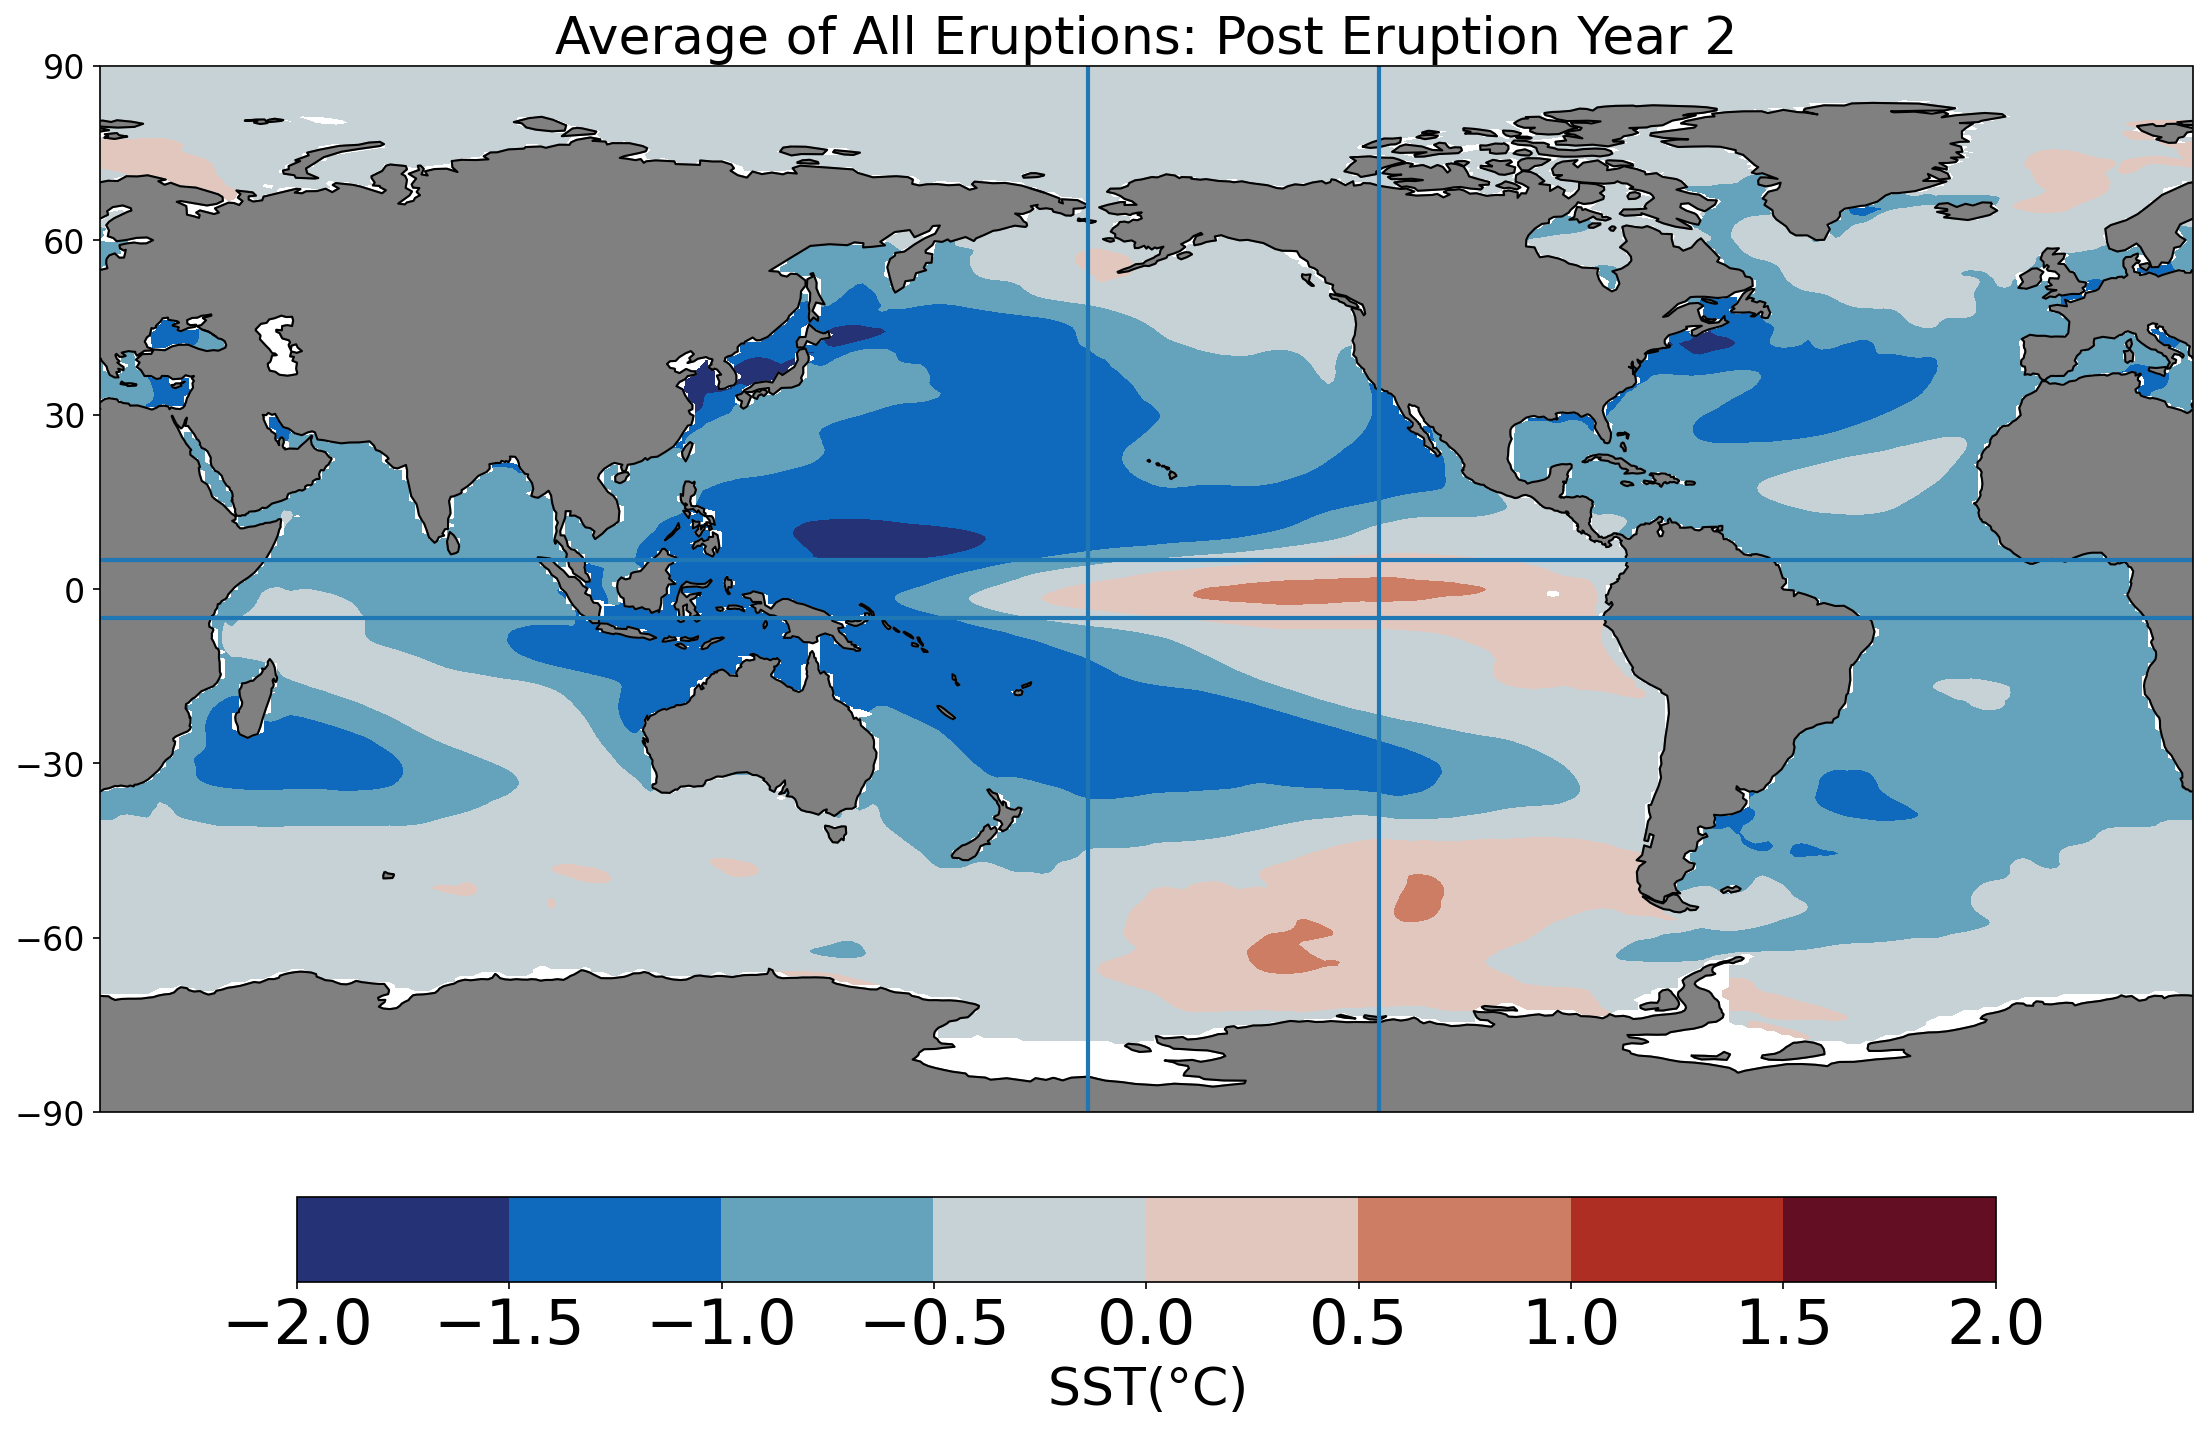

In [37]:
projection=ccrs.PlateCarree(central_longitude = -160)
fig,ax= plt.subplots(figsize =(18,15),subplot_kw=dict(projection=projection))

ax.add_feature(cfeature.LAND, color = 'gray')
ax.add_feature(cfeature.COASTLINE)
ax.set_global()

levels=np.arange(-2, 2.5,0.5)
p = plt.contourf(new_lons,new_lats, plot_data_2yr_average,levels=levels,
                transform=ccrs.PlateCarree(),cmap = cmocean.cm.balance,zorder=-1)
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=projection)
plt.axhline(y=5)
plt.axhline(y=-5)
plt.axvline(x=-10)
plt.axvline(x=40)
plt.title('Average of All Eruptions: Post Eruption Year 2', size =25)
cbar = plt.colorbar(p, orientation='horizontal', pad=0.05, fraction=0.05,ax=ax)
cbar.ax.tick_params(labelsize=30)
cbar.set_label('SST' + "($\degree$C)", size = 25)

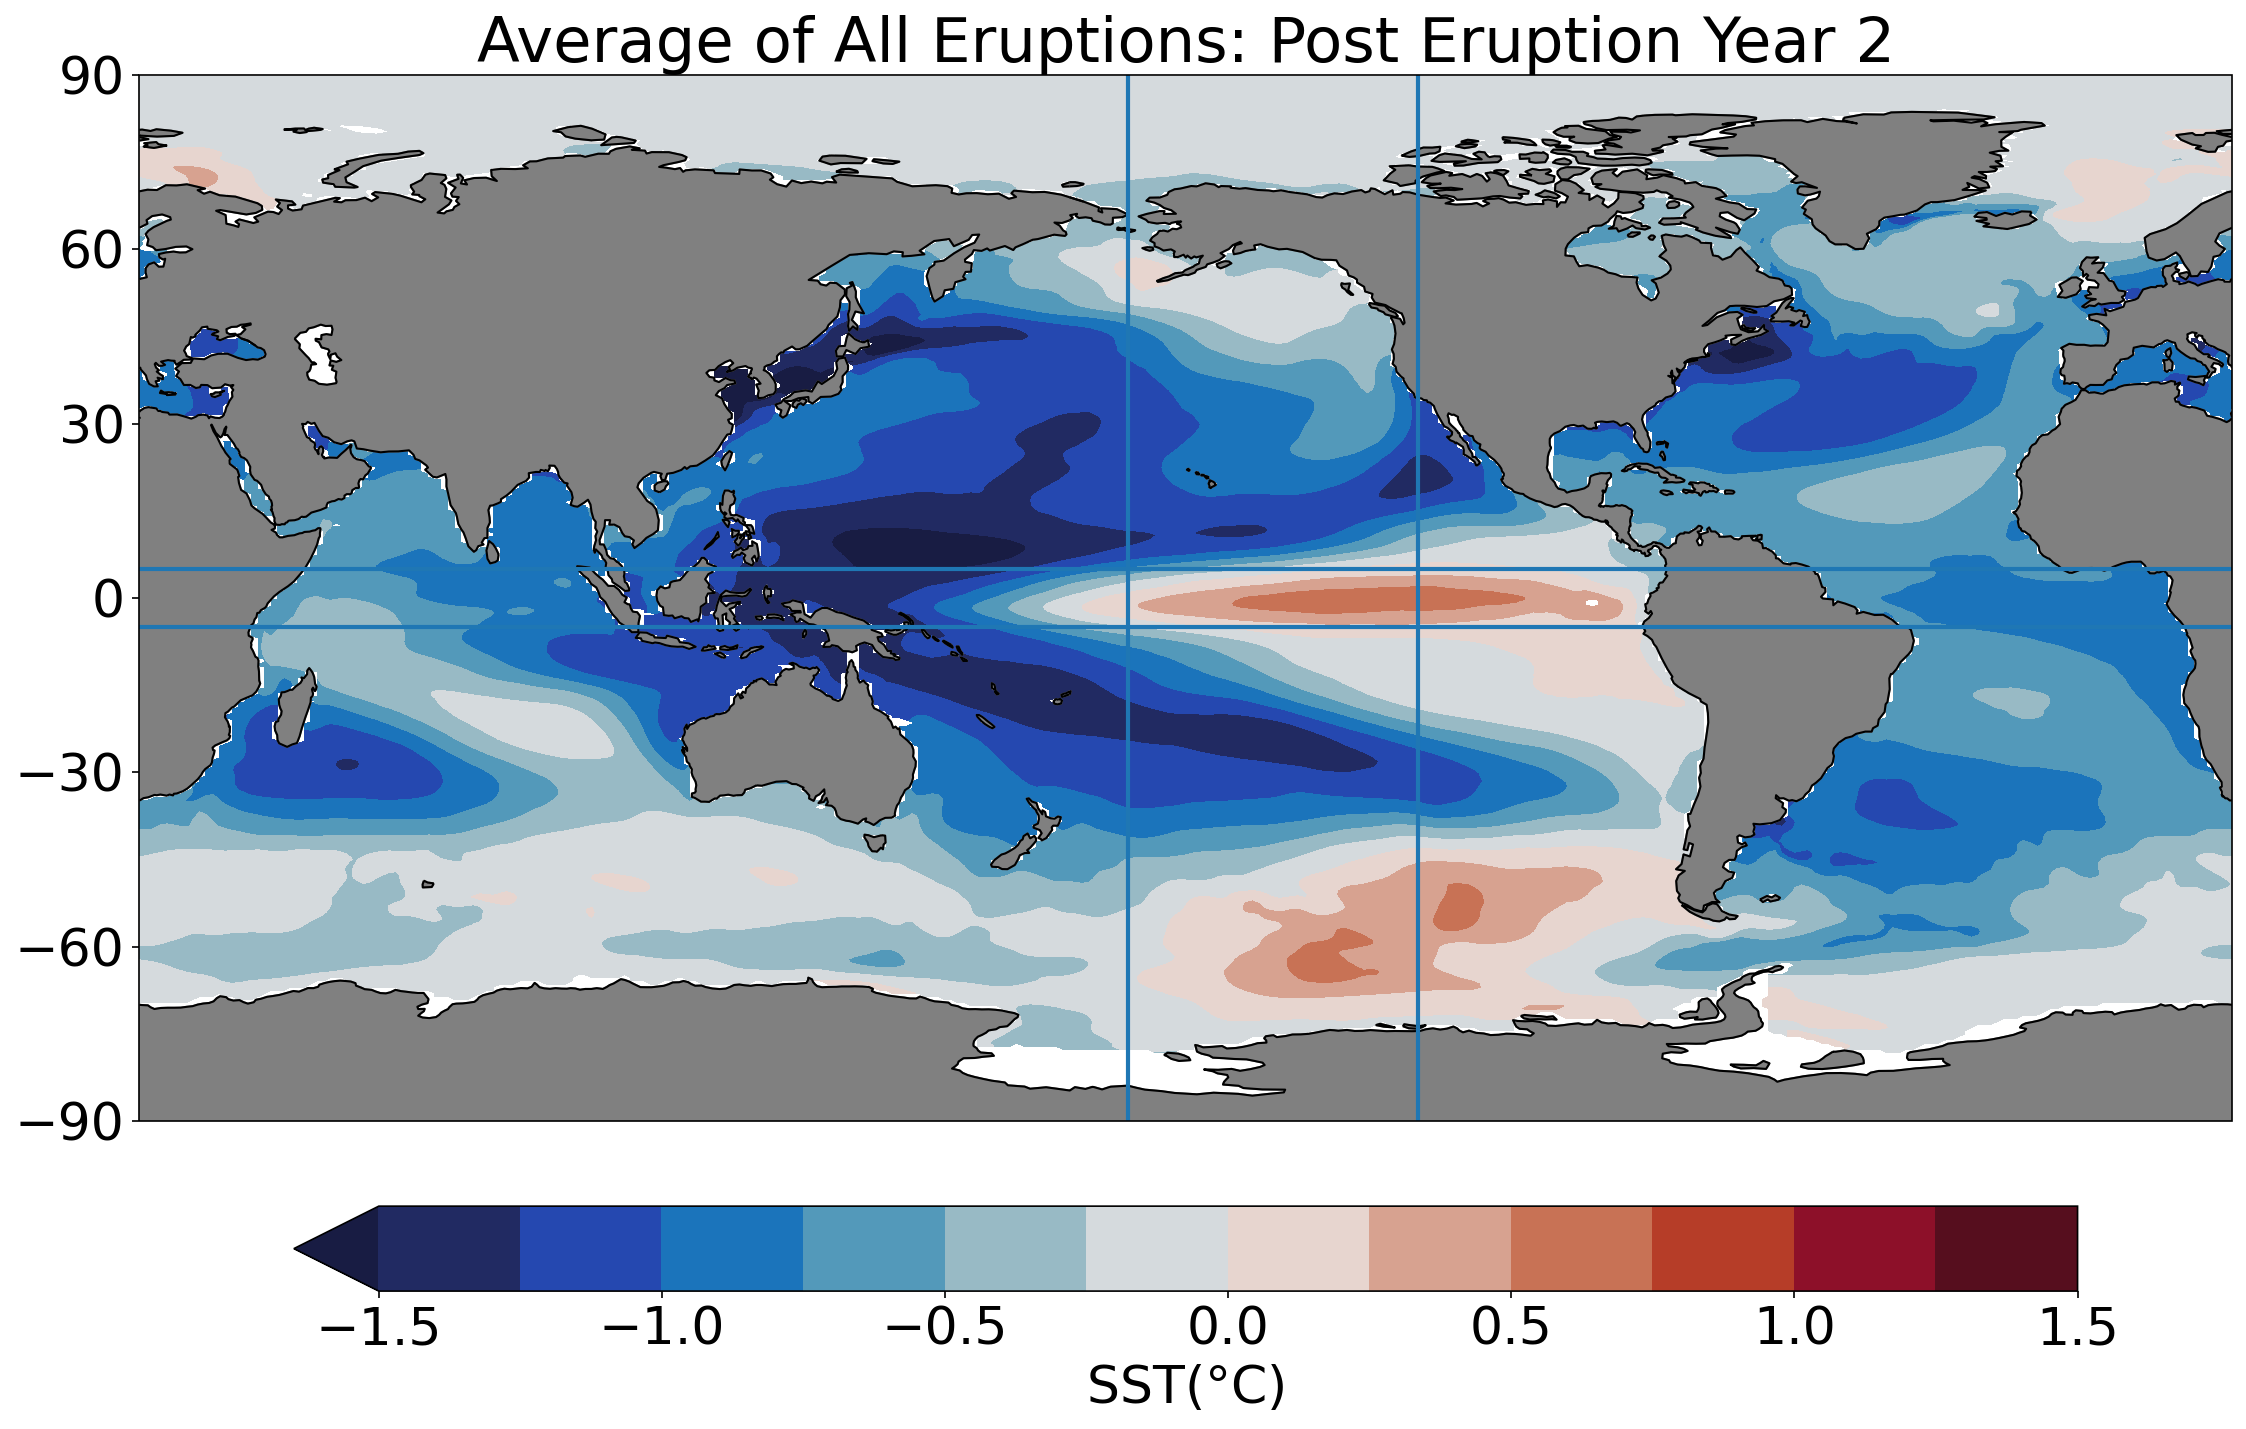

In [5]:
projection=ccrs.PlateCarree(central_longitude = -160)
fig,ax= plt.subplots(figsize =(18,15),subplot_kw=dict(projection=projection))

ax.add_feature(cfeature.LAND, color = 'gray')
ax.add_feature(cfeature.COASTLINE)
ax.set_global()

#levels=np.arange(-2, 2.1,0.25)
min_level=-1.5
max_level=1.5
step_level=0.25

levels = np.arange(min_level, max_level + step_level, step_level)
p = plt.contourf(new_lons,new_lats, plot_data_2yr_average,extend='min',levels=levels,
                transform=ccrs.PlateCarree(),cmap = cmocean.cm.balance,zorder=-1)
plt.yticks([-90, -60, -30, 0, 30, 60, 90], size=25)
plt.axhline(y=5)
plt.axhline(y=-5)
plt.axvline(x=-10)
plt.axvline(x=40)
plt.title('Average of All Eruptions: Post Eruption Year 2', size=30)
cbar = plt.colorbar(p, orientation='horizontal', pad=0.05, fraction=0.05,ax=ax)
cbar.ax.tick_params(labelsize=25)
cbar.set_label('SST' + "($\degree$C)", size = 25)